# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [3]:
import torch
from torchvision import datasets, transforms

In [5]:
x = datasets.MNIST('data', download = True)
x[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



13.2%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Failed to download (trying next):
HTTP Error 403: Forbidden

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100.0%

Failed to download (trying next):
HTTP Error 403: Forbidden



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28>, 5)

In [6]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [7]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [8]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [9]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

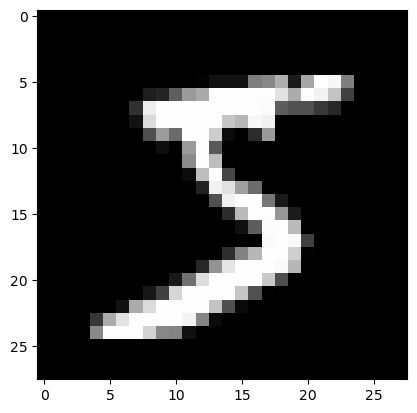

In [10]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

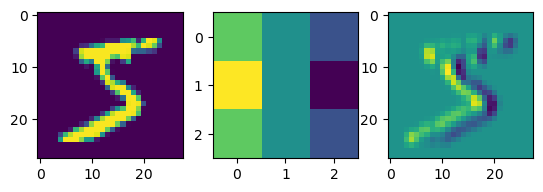

In [11]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [14]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [15]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

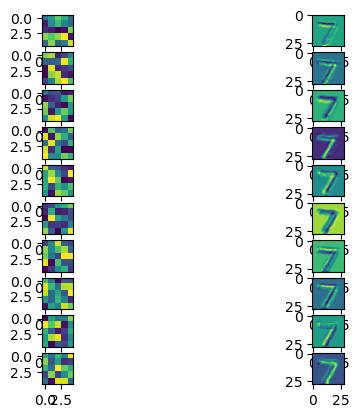

In [16]:
visualize()

# Predict Using Network

In [17]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [18]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([2, 9, 6, 9, 6])

# First Test and Train

In [19]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [20]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 11%



In [21]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [22]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.301114
Train loss: 2.099647
Train loss: 1.221353
Train loss: 0.776642
Train loss: 0.725953
Train loss: 0.695524
Train loss: 0.535290
Train loss: 0.647996
Train loss: 0.505669
Train loss: 0.787164


# Train Network

In [23]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.300759
Train loss: 1.957697
Train loss: 1.069431
Train loss: 1.083415
Train loss: 0.708197
Train loss: 0.687018
Train loss: 0.441743
Train loss: 0.367496
Train loss: 0.532877
Train loss: 0.695048
Test accuracy: 94%

Train loss: 0.369912
Train loss: 0.363058
Train loss: 0.348154
Train loss: 0.495039
Train loss: 0.281752
Train loss: 0.440133
Train loss: 0.360204
Train loss: 0.370489
Train loss: 0.318936
Train loss: 0.469757
Test accuracy: 96%

Train loss: 0.241066
Train loss: 0.254001
Train loss: 0.240434
Train loss: 0.365873
Train loss: 0.094222
Train loss: 0.286174
Train loss: 0.219238
Train loss: 0.286550
Train loss: 0.468751
Train loss: 0.373193
Test accuracy: 97%

Train loss: 0.271773
Train loss: 0.318748
Train loss: 0.209929
Train loss: 0.366035
Train loss: 0.199079
Train loss: 0.163257
Train loss: 0.174291
Train loss: 0.253108
Train loss: 0.359539
Train loss: 0.471588
Test accuracy: 98%

Train loss: 0.116655
Train loss: 0.211531
Train loss: 0.158454
Train loss: 0.331

# Inspect Network

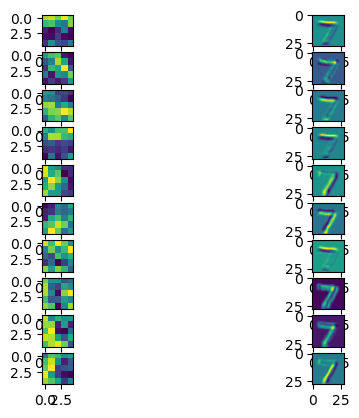

In [24]:
visualize()

In [25]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [26]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [27]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [28]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.315517
Train loss: 2.184671
Train loss: 1.349711
Train loss: 0.991830
Train loss: 0.710688
Test accuracy: 89%

Train loss: 0.649891
Train loss: 0.538337
Train loss: 0.399126
Train loss: 0.562011
Train loss: 0.550044
Test accuracy: 93%

Train loss: 0.480720
Train loss: 0.424264
Train loss: 0.490939
Train loss: 0.445701
Train loss: 0.431352
Test accuracy: 95%

Train loss: 0.281522
Train loss: 0.302235
Train loss: 0.292942
Train loss: 0.362708
Train loss: 0.334865
Test accuracy: 96%

Train loss: 0.324511
Train loss: 0.218941
Train loss: 0.266297
Train loss: 0.490974
Train loss: 0.272880
Test accuracy: 96%



In [ ]:
visualize()

## Question 1a

What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.291644
Train loss: 1.815989
Train loss: 1.078632
Train loss: 0.838302
Train loss: 0.690597
Train loss: 0.728389
Train loss: 0.489554
Train loss: 0.598251
Train loss: 0.440253
Train loss: 0.559218
Test accuracy: 93%

Train loss: 0.372252
Train loss: 0.476197
Train loss: 0.433078
Train loss: 0.432881
Train loss: 0.211897
Train loss: 0.404824
Train loss: 0.255254
Train loss: 0.579141
Train loss: 0.333249
Train loss: 0.556450
Test accuracy: 96%

Train loss: 0.302629
Train loss: 0.319421
Train loss: 0.324507
Train loss: 0.440431
Train loss: 0.190774
Train loss: 0.239558
Train loss: 0.250473
Train loss: 0.335387
Train loss: 0.356030
Train loss: 0.427654
Test accuracy: 97%

Train loss: 0.268567
Train loss: 0.238463
Train loss: 0.252426
Train loss: 0.263004
Train loss: 0.199665
Train loss: 0.227876
Train loss: 0.177974
Train loss: 0.258432
Train loss: 0.336755
Train loss: 0.458125
Test accuracy: 97%

Train loss: 0.272815
Train loss: 0.265125
Train loss: 0.214949
Train loss: 0.388

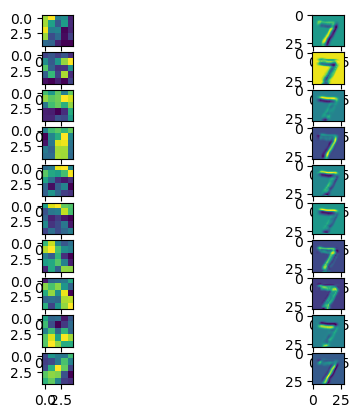

In [29]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()


Using 60,000 images, the accuracy starts at around 93% after one epoch of training and seems to cap at around 97% after 5 epochs. 

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.303856
Train loss: 1.969507
Train loss: 1.120850
Train loss: 0.679044
Train loss: 0.699643
Test accuracy: 90%

Train loss: 0.582618
Train loss: 0.440848
Train loss: 0.480718
Train loss: 0.492895
Train loss: 0.407294
Test accuracy: 94%

Train loss: 0.487219
Train loss: 0.436365
Train loss: 0.292631
Train loss: 0.472410
Train loss: 0.346751
Test accuracy: 95%

Train loss: 0.386430
Train loss: 0.400702
Train loss: 0.283992
Train loss: 0.418571
Train loss: 0.210602
Test accuracy: 96%

Train loss: 0.196754
Train loss: 0.301042
Train loss: 0.254937
Train loss: 0.401871
Train loss: 0.313609
Test accuracy: 97%



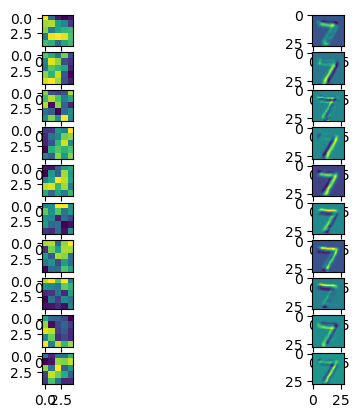

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()


With 30,000 images the accuracy begins around 90% and caps at around 97% after 5 epochs.

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.356372
Test accuracy: 54%

Train loss: 2.041335
Test accuracy: 79%

Train loss: 1.218191
Test accuracy: 86%

Train loss: 0.978114
Test accuracy: 90%

Train loss: 0.767462
Test accuracy: 91%



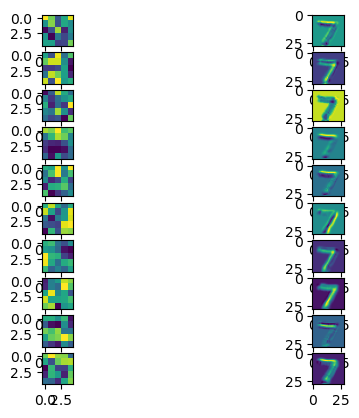

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()


With 6,000 images, the accuracy begins around 54% after 1 epoch of training and caps at around 91% after 5. 

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.317172
Test accuracy: 46%

Train loss: 2.212063
Test accuracy: 59%

Train loss: 2.010204
Test accuracy: 68%

Train loss: 1.512648
Test accuracy: 77%

Train loss: 1.273423
Test accuracy: 84%



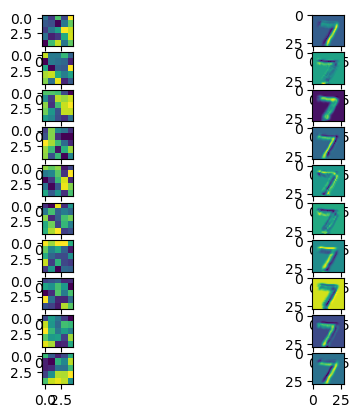

In [32]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()


With 3,000 images, the accuracy begins around 46% after one epoch and caps around 84% after 5 epochs. 

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_29524/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.350929
Test accuracy: 10%

Train loss: 2.303585
Test accuracy: 10%

Train loss: 2.308586
Test accuracy: 10%

Train loss: 2.252901
Test accuracy: 19%

Train loss: 2.221922
Test accuracy: 29%



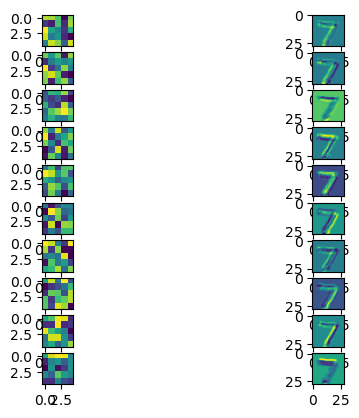

In [33]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()


With only 600 images, the accuracy begins around 10% after one epoch and only achieves 29% after 5 epochs. It seems like 30,000 images is the best range in ordert to have high accuracy and still maintain more efficiency than 60,000 images. 

## Question 1B

When trained with 60,000 images, the weights look very non-random and like they predict image elements at high accuracy. When trained on only 600 images, the weights look more random and poorly defined.  